In [1]:
## standard packages
import pandas as pd
import numpy as np
from scipy import special

## visualization packages
import plotly.express as px
import plotly.graph_objects as go

## Model packages
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error

## Shap 
import shap

## settings
pd.set_option('display.max_columns', None)

# Motivational Example B - XGBoost MTA With Controls

In this notebook we build on the basic logistic regression approach by:

1) introducing some control (non marketing touchpoint) variables

2) using shap to get varying MTA weights based on channel frequency, channel presence interactions, and control context

This solution will not contain:

 - how to incorporate touchpoint proximity (the idea that far away touches might deserve no or little contribution vs touches that occur in close proximity to conversion)
 
 - how to incorporate sequence or position based weights

In [2]:
## Import Dataset, this time we need to pull in the visitor id table as well

sequence_df = pd.read_csv('../datasets/sequence_fact.csv')
visitor_detail_df = pd.read_csv('../datasets/visitor_detail.csv')

##Make a bridge table of sequence id to visitor id
sequence_to_visitor_map = sequence_df[['sequence_id','fullVisitorId']].drop_duplicates().reset_index(drop=True)

sequence_df.head(10)

sequence_id        fullVisitorId      event_name       event_datetime  \
0  0099Rqojoj1MCXN  7343617347507729080  organic_search  2018-04-15 17:31:50   
1  0099Rqojoj1MCXN  7343617347507729080        dead_end  2018-04-15 17:33:05   
2  00A9Lkka73okUx2    89656057821147903  organic_search  2017-09-14 16:36:56   
3  00A9Lkka73okUx2    89656057821147903        dead_end  2017-09-14 16:54:09   
4  00B30tmbMwJn7Cf  4307745811624101170  organic_search  2017-04-21 02:41:23   
5  00B30tmbMwJn7Cf  4307745811624101170        dead_end  2017-04-21 02:41:24   
6  00BKxKnEYlKbw9b  7129167701457127936  organic_search  2016-10-02 15:16:09   
7  00BKxKnEYlKbw9b  7129167701457127936        dead_end  2016-10-02 15:16:10   
8  00EttOfsTTyp45B  3217678225016118393        referral  2017-10-23 19:44:20   
9  00EttOfsTTyp45B  3217678225016118393        dead_end  2017-10-23 19:46:43   

   conversion_proximity  
0                  75.0  
1                   0.0  
2                1033.0  
3                   0.0  
4                   1.0  
5                   0.0  
6                   1.0  
7                   0.0  
8                 143.0  
9                   0.0

In [3]:
## filter conversion_proximity 
model_prep_df1 = sequence_df.loc[(sequence_df['conversion_proximity']/86400)<=45,:]

In [4]:
## make the sequence details
model_prep_df2 = model_prep_df1.groupby('sequence_id')['event_name'].agg(lambda x: '>'.join(x)).reset_index()
model_prep_df2.columns = ['sequence_id','sequence_details']
model_prep_df2.head()

sequence_id         sequence_details
0  0099Rqojoj1MCXN  organic_search>dead_end
1  00A9Lkka73okUx2  organic_search>dead_end
2  00B30tmbMwJn7Cf  organic_search>dead_end
3  00BKxKnEYlKbw9b  organic_search>dead_end
4  00EttOfsTTyp45B        referral>dead_end

In [5]:
## make the modeling features
model_prep_df3 = model_prep_df1.pivot_table(index='sequence_id', columns='event_name', aggfunc='size', fill_value=0).reset_index()
model_prep_df3 = model_prep_df3.rename_axis(None, axis=1)
model_prep_df3.head()

sequence_id  (other)  affiliates  conversion  dead_end  direct  \
0  0099Rqojoj1MCXN        0           0           0         1       0   
1  00A9Lkka73okUx2        0           0           0         1       0   
2  00B30tmbMwJn7Cf        0           0           0         1       0   
3  00BKxKnEYlKbw9b        0           0           0         1       0   
4  00EttOfsTTyp45B        0           0           0         1       0   

   display  organic_search  paid_search  referral  social  
0        0               1            0         0       0  
1        0               1            0         0       0  
2        0               1            0         0       0  
3        0               1            0         0       0  
4        0               0            0         1       0

In [6]:
## Final joining and prep
model_prep_df4 = model_prep_df2.merge(model_prep_df3, on='sequence_id',how='left')

## Add visitor id back in
model_prep_df4 = model_prep_df4.merge(sequence_to_visitor_map, on='sequence_id',how='left')
model_prep_df4.head()

sequence_id         sequence_details  (other)  affiliates  conversion  \
0  0099Rqojoj1MCXN  organic_search>dead_end        0           0           0   
1  00A9Lkka73okUx2  organic_search>dead_end        0           0           0   
2  00B30tmbMwJn7Cf  organic_search>dead_end        0           0           0   
3  00BKxKnEYlKbw9b  organic_search>dead_end        0           0           0   
4  00EttOfsTTyp45B        referral>dead_end        0           0           0   

   dead_end  direct  display  organic_search  paid_search  referral  social  \
0         1       0        0               1            0         0       0   
1         1       0        0               1            0         0       0   
2         1       0        0               1            0         0       0   
3         1       0        0               1            0         0       0   
4         1       0        0               0            0         1       0   

         fullVisitorId  
0  7343617347507729080  
1    89656057821147903  
2  4307745811624101170  
3  7129167701457127936  
4  3217678225016118393

In [7]:
## Final joining and prep
model_prep_df4 = model_prep_df2.merge(model_prep_df3, on='sequence_id',how='left')

## Add visitor id back in
model_prep_df4 = model_prep_df4.merge(sequence_to_visitor_map, on='sequence_id',how='left')

## Add control variables, remap browser and continent, friendly control names
visitor_detail_small_df = visitor_detail_df[['fullVisitorId','device_deviceCategory','device_browser','geoNetwork_continent']]
model_prep_df5 = model_prep_df4.merge(visitor_detail_small_df, on='fullVisitorId',how='left')

browser_list = ['Chrome','Safari','Firefox','Internet Explorer', 'Edge']
continent_list = ['Americas','Asia','Europe','Other']
model_prep_df5['device_browser'] = np.where(model_prep_df5['device_browser'].isin(browser_list), model_prep_df5['device_browser'], 'Other')
model_prep_df5['geoNetwork_continent'] = np.where(model_prep_df5['geoNetwork_continent'].isin(continent_list), model_prep_df5['geoNetwork_continent'], 'Other')

model_prep_df5.rename(columns={'device_deviceCategory':'device_type','geoNetwork_continent':'geo_continent'},inplace=True)


## drop dead_end and move Y to last spot
model_prep_df5 =  model_prep_df5[['fullVisitorId','device_type','device_browser','geo_continent'
                                 ,'sequence_id','sequence_details','affiliates'
                                 ,'direct','display','organic_search'
                                 ,'paid_search','referral','social'
                                 ,'(other)','conversion']]

model_prep_df5.head()

fullVisitorId device_type device_browser geo_continent  \
0  7343617347507729080     desktop         Chrome          Asia   
1    89656057821147903      mobile         Chrome          Asia   
2  4307745811624101170      tablet         Safari      Americas   
3  7129167701457127936      mobile         Safari      Americas   
4  3217678225016118393     desktop         Chrome      Americas   

       sequence_id         sequence_details  affiliates  direct  display  \
0  0099Rqojoj1MCXN  organic_search>dead_end           0       0        0   
1  00A9Lkka73okUx2  organic_search>dead_end           0       0        0   
2  00B30tmbMwJn7Cf  organic_search>dead_end           0       0        0   
3  00BKxKnEYlKbw9b  organic_search>dead_end           0       0        0   
4  00EttOfsTTyp45B        referral>dead_end           0       0        0   

   organic_search  paid_search  referral  social  (other)  conversion  
0               1            0         0       0        0           0  
1               1            0         0       0        0           0  
2               1            0         0       0        0           0  
3               1            0         0       0        0           0  
4               0            0         1       0        0           0

In [8]:
## for final modeling data we will need to, drop id columns that cannot be modeled on, and one hot encode categorical features such as device_type

## drop non modeling columns
model_prep_df6 = model_prep_df5.drop(columns=['fullVisitorId','sequence_id','sequence_details'])

columns_for_ohe = ['device_type','device_browser','geo_continent']

model_data_final = pd.get_dummies(model_prep_df6,columns=columns_for_ohe)

def move_column_to_last(df, column_name):
    cols = df.columns.tolist()
    cols.remove(column_name)
    cols.append(column_name)
    return df[cols]

# Add a random coin flip column
model_data_final['random_noise_1'] = np.random.choice([0, 1], size=len(model_data_final))

# Add a uniform draw from 0-10000 column
model_data_final['random_noise_2'] = np.random.randint(0, 10001, size=len(model_data_final))

# Add a random normal draw
model_data_final['random_noise_3'] = np.random.normal(loc=2, scale=1, size=len(model_data_final))

model_data_final = move_column_to_last(model_data_final, 'conversion')

model_data_final = model_data_final.rename(columns=str.lower)

##lets add specification if a variable is channel or control

def append_suffix(df, col_list, no_suffix_list):
    # Iterate over columns in the DataFrame
    for col in df.columns:
        # Check if the column is in the first list
        if col in col_list:
            # Append '_channel' to the column name
            new_col_name = col + '_channel'
        # Check if the column is in the second list
        elif col in no_suffix_list:
            # Do not append any suffix to the column name
            new_col_name = col
        else:
            # Append '_abc' to the column name
            new_col_name = col + '_control'
        
        # Rename the column in the DataFrame
        df = df.rename(columns={col: new_col_name})
    
    return df

channel_list = ['affiliates','direct','display','organic_search','paid_search','referral','social','(other)']
target_var = ['random_noise_1','random_noise_2', 'random_noise_3','conversion']

model_data_final = append_suffix(model_data_final, channel_list, target_var)
model_data_final.head()

affiliates_channel  direct_channel  display_channel  \
0                   0               0                0   
1                   0               0                0   
2                   0               0                0   
3                   0               0                0   
4                   0               0                0   

   organic_search_channel  paid_search_channel  referral_channel  \
0                       1                    0                 0   
1                       1                    0                 0   
2                       1                    0                 0   
3                       1                    0                 0   
4                       0                    0                 1   

   social_channel  (other)_channel  device_type_desktop_control  \
0               0                0                            1   
1               0                0                            0   
2               0                0                            0   
3               0                0                            0   
4               0                0                            1   

   device_type_mobile_control  device_type_tablet_control  \
0                           0                           0   
1                           1                           0   
2                           0                           1   
3                           1                           0   
4                           0                           0   

   device_browser_chrome_control  device_browser_edge_control  \
0                              1                            0   
1                              1                            0   
2                              0                            0   
3                              0                            0   
4                              1                            0   

   device_browser_firefox_control  device_browser_internet explorer_control  \
0                               0                                         0   
1                               0                                         0   
2                               0                                         0   
3                               0                                         0   
4                               0                                         0   

   device_browser_other_control  device_browser_safari_control  \
0                             0                              0   
1                             0                              0   
2                             0                              1   
3                             0                              1   
4                             0                              0   

   geo_continent_americas_control  geo_continent_asia_control  \
0                               0                           1   
1                               0                           1   
2                               1                           0   
3                               1                           0   
4                               1                           0   

   geo_continent_europe_control  geo_continent_other_control  random_noise_1  \
0                             0                            0               1   
1                             0                            0               1   
2                             0                            0               1   
3                             0                            0               0   
4                             0                            0               0   

   random_noise_2  random_noise_3  conversion  
0            7360        2.351923           0  
1            2476        2.540523           0  
2            5160        1.259182           0  
3            3853        1.408095           0  
4            5203        1.643502           0

## Train Validate Test

There are different ways to go about holdout and performance evaluation. Some might even argue you need to do double cross validation or nested cross validation.

For this project we will follow a pretty typical ML flow of train, validate, test. With modeling data split 60, 20, 20 respectively.

Train - we use to fit models

Validate - we use to evaluate all sorts of models, model hyperpameters, and feature selection procedures

Test - A final test not seen until the vary end to give us a number to report to stakeholders on what they can expect performance to be. This data is not to be used for model selection or hyperparameter tuning. Sometimes we can make this an out of time holdout to perhaps show how the model might perform when it is run on data for next month for example. For now we won't wory about this. 

In [9]:
model_data_final.shape

(99718, 25)

In [10]:
X = model_data_final.iloc[:,:-1]
y = model_data_final[['conversion']]

X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the temp set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.25, random_state=42)

# Print the sizes of each set
print("Train set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))

Train set size: 59830
Validation set size: 19944
Test set size: 19944


## Smart Automated Feature Selection for XGBoost

1) We will always want to keep all our marketing touchpoints regardless of predictive signal that is a business requirement

2) When it comes to control variables, if xgboost doesn't need or like one of these variables we can remove it from modeling to improve predictive performance

3) It is a common mistake to look at feature importance or shap importance and then to arbitrarily remove some of the last important features when comparing them to eachother and experiment that way.

4) There are some drawbacks to this approach as it is kind of manual, subjective and just because a feature has low importance compared to other features doesn't mean it isn't providing predictive performance value.

5) A better method is to ask, does my feature perform better than a random noise variable? A more sophisticated aproach is called Boruta but for now we will just generate our own random noise variables. Then when we look at feature importance "gain" we will keep all variables that have better gain than our random noise variables.

The process should look like this.

Train a kitchen sink model using a small grid. Use Boruta or random noise variables to remove unnecessary features. Train feature reduced model. 

Then procede to hyperparamter tuning.

From the EDA I actually expect there to be value in all the controls we have brought in at the moment for this dataset. 

However in practice you might have 50-500 features and you can get an optimal xgboost model using just 10-50 features most likely. 

In [11]:
X_train2 = X_train.iloc[:,:-3]
X_val2 = X_val.iloc[:,:-3]
X_test2 = X_test.iloc[:,:-3]

In [12]:
#### Kitchen sink (all variables except noise variables)

# create XGBoost classifier
kitchen_sink_xgb = XGBClassifier(eval_metric='logloss')

# define hyperparameters to tune
param_grid = {
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [500, 1000],
    'colsample_bytree': [0.8],
    'subsample': [0.8]
}

# create grid search object
grid_search = GridSearchCV(estimator=kitchen_sink_xgb, param_grid=param_grid, cv=3, scoring='neg_log_loss', verbose=2)

# fit the grid search object to the training data
grid_search.fit(X_train2, y_train)

# get the best hyperparameters from the grid search
best_params = grid_search.best_params_

print(best_params)

# create XGBoost classifier with best hyperparameters
best_kitchen_sink_xgb = XGBClassifier(**best_params)

# fit the classifier to the training data
best_kitchen_sink_xgb.fit(X_train2, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=500, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=500, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=500, subsample=0.8; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=1000, subsample=0.8; total time=   3.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=1000, subsample=0.8; total time=   3.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=1000, subsample=0.8; total time=   3.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.8; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.8; total time=   2.2s
[CV] END

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [13]:
train_pred = best_kitchen_sink_xgb.predict_proba(X_train2)[:, 1]
val_pred = best_kitchen_sink_xgb.predict_proba(X_val2)[:, 1]

train_auc = roc_auc_score(y_train, train_pred)
val_auc = roc_auc_score(y_val, val_pred)

print("Train AUC:", train_auc)
print("Validate AUC:", val_auc)

Train AUC: 0.9037871004725866
Validate AUC: 0.8985169968970479


Best kitchen sink is a 10 point improvement to AUC over logistic! Also train and test AUC is close meaning we aren't overfitting. This is a really big deal.

AUC interpretation means if you gave the model 1 random conversion and 1 random nonconversion it could tell you which one is the conversion 90% of the time. AUC can also be thought of an ordering/rank metric. The better the AUC the better the model is at ordering the data from highest probability to lowest probability.

Next we can look at feature importance. The recommended importance metric for xgboost is gain. Gain provides a measure of how useful a feture is for making predictions in the XGBoost model. 

Interpreting the gain feature importance:
- Higher gain importance indicates that a feature contributes more to the model's predictive performance, suggesting it has a stronger relationship with the target variable.
- Lower gain importance implies that the feature has less impact on the model's predictions.

Limitations of gain feature importance:
- Gain importance does not provide information about the direction (positive or negative) of the relationship between a feature and the target variable. It only indicates the overall importance.
- It does not capture potential feature interactions, as it considers each feature individually.
- The actual gain values don't mean much it is just best to look at the relative relationship between the different scores.
- Some feature elimination exercises might recommend looking at low gain features to drop features from the model. This isn't as viable as the solution we will highlight below.

In [14]:
# Get feature importances based on gain
importances = best_kitchen_sink_xgb.get_booster().get_score(importance_type='gain')

# Create a pandas DataFrame
df_importances = pd.DataFrame({'Feature': list(importances.keys()), 'Gain Importance': list(importances.values())})

# Sort DataFrame by 'Gain Importance' in descending order
df_importances = df_importances.sort_values(by='Gain Importance', ascending=False)

df_importances['Marketing Channel Feature'] = np.where(df_importances['Feature'].str.contains('_control'), 'no', 'yes')


bar_fig = px.bar(df_importances
                 ,x='Gain Importance'
                 ,y='Feature'
                 ,title='Gain Importance for Each Feature'
                 ,color='Marketing Channel Feature'
                 )

bar_fig.update_layout(width=950
                      ,height=600
                      ,yaxis={'categoryorder': 'total ascending'}
                      ,plot_bgcolor='#f2f2f2') 

bar_fig.show()

In [15]:
#### Model with noise variables

# create XGBoost classifier
feature_select_xgb = XGBClassifier(eval_metric='logloss')

# define hyperparameters to tune
param_grid = {
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [500, 1000],
    'colsample_bytree': [0.8],
    'subsample': [0.8]
}

# create grid search object
grid_search = GridSearchCV(estimator=feature_select_xgb, param_grid=param_grid, cv=3, scoring='neg_log_loss', verbose=2)

# fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# get the best hyperparameters from the grid search
best_params = grid_search.best_params_

print(best_params)

# create XGBoost classifier with best hyperparameters
best_feature_select_xgb = XGBClassifier(**best_params)

# fit the classifier to the training data
best_feature_select_xgb.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=500, subsample=0.8; total time=   3.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=500, subsample=0.8; total time=   3.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=500, subsample=0.8; total time=   3.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=1000, subsample=0.8; total time=   6.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=1000, subsample=0.8; total time=   6.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=1000, subsample=0.8; total time=   6.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.8; total time=   4.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.8; total time=   4.3s
[CV] END

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [16]:
train_pred = best_feature_select_xgb.predict_proba(X_train)[:, 1]
val_pred = best_feature_select_xgb.predict_proba(X_val)[:, 1]

train_auc = roc_auc_score(y_train, train_pred)
val_auc = roc_auc_score(y_val, val_pred)

print("Train AUC:", train_auc)
print("Validate AUC:", val_auc)

Train AUC: 0.9080749131485395
Validate AUC: 0.8952542125939078


In [17]:
# Get feature importances based on gain
importances = best_feature_select_xgb.get_booster().get_score(importance_type='gain')

# Create a pandas DataFrame
df_importances = pd.DataFrame({'Feature': list(importances.keys()), 'Gain Importance': list(importances.values())})

# Sort DataFrame by 'Gain Importance' in descending order
df_importances = df_importances.sort_values(by='Gain Importance', ascending=False)

df_importances['Feature Type'] = np.where(df_importances['Feature'].str.contains('_control'), 'control'
                                                       ,np.where(df_importances['Feature'].str.contains('_noise'), 'noise','marketing channel'))


bar_fig = px.bar(df_importances
                 ,x='Gain Importance'
                 ,y='Feature'
                 ,title='Gain Importance for Each Feature'
                 ,color='Feature Type'
                 )

bar_fig.update_layout(width=950
                      ,height=600
                      ,yaxis={'categoryorder': 'total ascending'}
                      ,plot_bgcolor='#f2f2f2') 

bar_fig.show()

#### we can automate feature selection now, by:

1) keep all marketing channels as it is required

2) remove all controls that ranked relatively worse in gain than random noise variables

In [18]:
max_noise_gain = df_importances.loc[df_importances['Feature Type']=='noise',:]['Gain Importance'].max()

## keep feature if feature is marketing channel OR control gain is greater than max noise gain
df_importances_reduced = df_importances[df_importances['Feature'].str.contains('_channel') | (df_importances['Gain Importance'] > max_noise_gain)]

new_reduced_X_list = df_importances_reduced['Feature'].to_list()
new_reduced_X_list

['geo_continent_americas_control',
 'device_type_desktop_control',
 'referral_channel',
 'device_type_mobile_control',
 'social_channel',
 'direct_channel',
 'geo_continent_asia_control',
 'geo_continent_europe_control',
 'organic_search_channel',
 'device_browser_chrome_control',
 'affiliates_channel',
 'paid_search_channel',
 'display_channel']

In [19]:
X_train3 = X_train.loc[:,new_reduced_X_list]
X_val3 = X_val.loc[:,new_reduced_X_list]
X_test3 = X_test.loc[:,new_reduced_X_list]

In [20]:
#### Final Model

# create XGBoost classifier
final_xgb = XGBClassifier(eval_metric='logloss')

# define hyperparameters to tune
param_grid = {
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [500, 1000],
    'colsample_bytree': [0.8],
    'subsample': [0.8]
}

# create grid search object
grid_search = GridSearchCV(estimator=feature_select_xgb, param_grid=param_grid, cv=3, scoring='neg_log_loss', verbose=2)

# fit the grid search object to the training data
grid_search.fit(X_train3, y_train)

# get the best hyperparameters from the grid search
best_params = grid_search.best_params_

print(best_params)

# create XGBoost classifier with best hyperparameters
best_final_xgb = XGBClassifier(**best_params)

# fit the classifier to the training data
best_final_xgb.fit(X_train3, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=500, subsample=0.8; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=500, subsample=0.8; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=500, subsample=0.8; total time=   2.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=1000, subsample=0.8; total time=   5.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=1000, subsample=0.8; total time=   5.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=1000, subsample=0.8; total time=   3.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.8; total time=   3.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.8; total time=   3.5s
[CV] END

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [21]:
train_pred = best_final_xgb.predict_proba(X_train3)[:, 1]
val_pred = best_final_xgb.predict_proba(X_val3)[:, 1]
test_pred = best_final_xgb.predict_proba(X_test3)[:, 1]

train_auc = roc_auc_score(y_train, train_pred)
val_auc = roc_auc_score(y_val, val_pred)
test_auc = roc_auc_score(y_test, test_pred)

print("Train AUC:", train_auc)
print("Validate AUC:", val_auc)
print("Test AUC:", test_auc)

Train AUC: 0.9016914809387493
Validate AUC: 0.8969314700761994
Test AUC: 0.8965255163017565


We were able to eliminate some control features without noteably impacting AUC. Generally speaking, simpler models will generalize to new data better and are prefered over more complex solutions. This is also referred to as Occam's razor prinipal.

## Deploy new model

####  Part 1 Shap Explainer & Attribution Transformations

With XGBoost this is much more complicated. Unlike logistic there aren't static weights to leverage. The following is one proposed solution. We will use SHAP explanations to get row level "impacts" for the features. We will use softmax transformation row by row to get impacts. We will then use these weights row by row to divy up conversions only.

Let's start with looking at some shap results and trying this approach with 1 row. 

In [22]:
X = model_data_final.loc[:,new_reduced_X_list]

explainer = shap.Explainer(best_final_xgb)
shap_values = explainer(X)

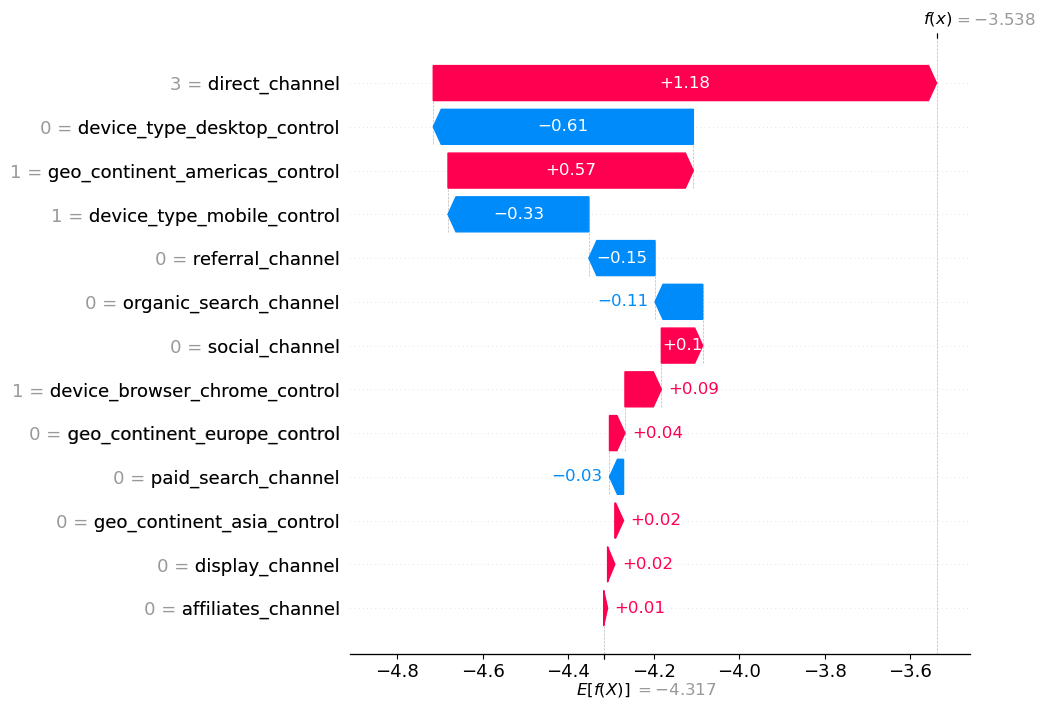

In [23]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[100],  max_display=18)

In [40]:
odds_ratio = np.exp(-3.5)
odds_ratio

0.0301973834223185

Here we can view the general impacts in log odds across all observations. 

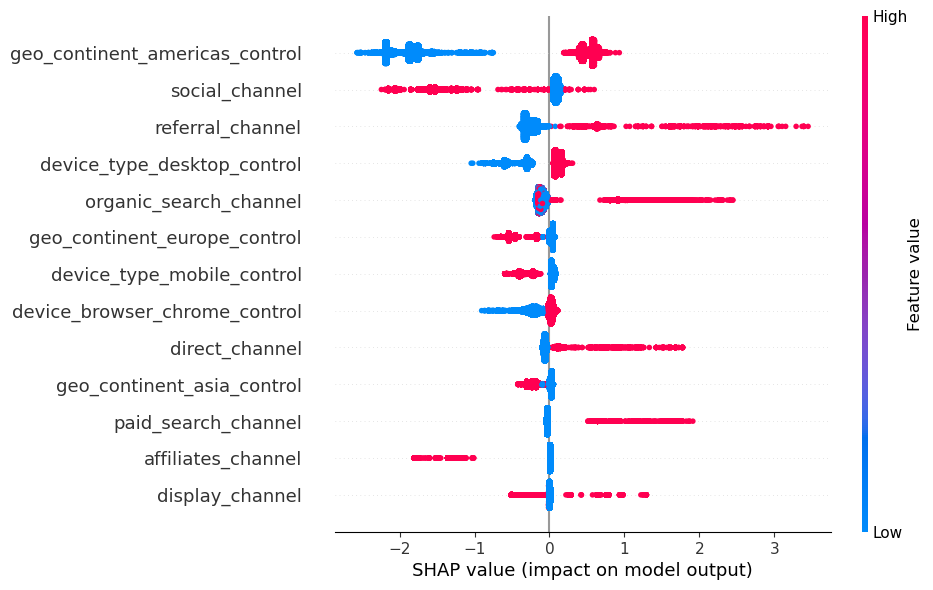

In [25]:
shap.plots.beeswarm(shap_values,  max_display=18)

Recall these previously shared attribution "rules"

To divy up these conversion credits we would need to meet the following rules.
- If a touchpoint is present but no conversion it gets zero credit for a conversion
- If a touchpoint is present but there is a conversion it gets >= 0 credit for a conversion
- If a touchpoint is not present it gets no credit and it gets no penalty either.

The shap values cannot be used directly as is for attribution because:

- we want a marketing channel to get 0 credit or 0 penalty when it is not present, but for shap methodology this can move the expected probability so there is positive or negative shap value when a marketing channel is "turned off" or absent.
- We only want credit to be assigned if there is a conversion, where in SHAP the probability always exists so there will be positive or negative shap values even when there is no conversion because the expectation of a conversion probability > 0 still exists.
- sometimes the marketing channel shap value is negative and it is generally an up front assumption in marketing attribution that marketing impact >= 0 (perhaps not true in reality)
    
We will adapt raw shap values to an attribution KPI by

- using softmax transform row by row (observation by observation), which will give us positive impacts only
- disregarding observations that were deadends (non-conversion), attribution wants to divy up our actual conversions only
- weights of marketing channels that are "off" get are considered as control weights, in the attribution game we shouldn't reward or penalize a tactic when it wasn't present

In [26]:
## helper function that gets used in the following function
def marketing_control(row):
    """
    This will add up any off channel attribution results and push them into a singular marketing control column
    """
    marketing_control_sum = 0
    channel_list = [x for x in new_reduced_X_list if '_channel' in x]
    
    for i in channel_list:
        data = row['{}'.format(i)]
        value  = row['{}_shap_attribution'.format(i)]
        
        if data == 0:
            marketing_control_sum += value
            
    return marketing_control_sum


####  attribution shap transform function
def attribution_shap_transform(model, X, control_vars, markeing_vars):
    """
    Pass the final fitted model object to get shap explainations 
    
    Pass an X dataframe of observations to use in shap explainations (includes both conversion and nonconversion)
    
    Pass a list of the control vars and a list of marketing vars
    
    Will return a dataframe with attribution transformed explaination for each conversion
    """
    
    explainer = shap.Explainer(model)
    
    shap_values = explainer(X)
    shap_data_df = pd.DataFrame(shap_values.data, columns=X.columns)

    #values
    shap_value_df = pd.DataFrame(shap_values.values, columns=X.columns)
    shap_value_df = shap_value_df.add_suffix('_shap')

    #softmax 
    shap_value_df2 = shap_value_df.apply(lambda row: special.softmax(row.values), axis=1, result_type='expand')
    shap_value_df2.columns = shap_value_df.columns
    shap_value_df2 = shap_value_df2.add_suffix('_attribution')
    result_df = pd.concat([shap_data_df, shap_value_df, shap_value_df2, y],axis=1)

    ## If there is no conversion, no players get credit
    result_df.loc[result_df['conversion']==0, result_df.columns[result_df.columns.str.contains('_attribution')]] = 0

    ## If a marketing feature is off, copy the sum of those impacts to a marketing control column
    result_df['marketing_control_shap_attribution'] = result_df.apply(marketing_control,axis=1)

    ## If a marketing feature is off, now remove that impact since it is counted in marketing control 
    for i in marketing_vars:
        result_df.loc[result_df['{}'.format(i)]==0, '{}_shap_attribution'.format(i)] = 0


    ## detailed shap attribution dataframe
    result_df2 = result_df.filter(like='shap_attribution')
    
    
    return result_df2

In [27]:
## specifiy marketing vs control vars for funciton
marketing_vars =  [x for x in new_reduced_X_list if '_channel' in x]
control_vars = [x for x in new_reduced_X_list if '_control' in x]

# run shap marketing attribution function
attribution_result_df = attribution_shap_transform(best_final_xgb, X, control_vars, marketing_vars)

In [28]:
## merge attribution results with data
final_results_df = pd.concat([X, attribution_result_df, y],axis=1)

In [29]:
final_results_df.loc[final_results_df['conversion'] == 1, :]

geo_continent_americas_control  device_type_desktop_control  \
299                                 1                            1   
304                                 1                            1   
354                                 1                            1   
417                                 1                            1   
579                                 1                            1   
...                               ...                          ...   
99225                               1                            1   
99271                               1                            1   
99556                               1                            1   
99674                               1                            1   
99700                               1                            1   

       referral_channel  device_type_mobile_control  social_channel  \
299                   2                           0               0   
304                   0                           0               0   
354                   1                           0               0   
417                   0                           0               0   
579                   5                           0               0   
...                 ...                         ...             ...   
99225                 2                           0               0   
99271                 1                           0               0   
99556                 2                           0               0   
99674                 1                           0               0   
99700                 0                           0               0   

       direct_channel  geo_continent_asia_control  \
299                 0                           0   
304                 0                           0   
354                 0                           0   
417                 3                           0   
579                 0                           0   
...               ...                         ...   
99225               0                           0   
99271               0                           0   
99556               0                           0   
99674               0                           0   
99700               0                           0   

       geo_continent_europe_control  organic_search_channel  \
299                               0                       0   
304                               0                       2   
354                               0                       0   
417                               0                       0   
579                               0                       0   
...                             ...                     ...   
99225                             0                       0   
99271                             0                       0   
99556                             0                       0   
99674                             0                       0   
99700                             0                       0   

       device_browser_chrome_control  affiliates_channel  paid_search_channel  \
299                                1                   0                    0   
304                                0                   0                    0   
354                                1                   0                    0   
417                                1                   0                    0   
579                                1                   0                    0   
...                              ...                 ...                  ...   
99225                              1                   0                    0   
99271                              1                   0                    0   
99556                              1                   0                    0   
99674                              1                   0                    0   
99700                       

## Insights

- what portion of conversions are considered control/base vs marketing contributed?

- how many conversions came from each channel?

- per touchpoint, how many conversions come from each marketing channel?

- META LEARNING: given each channel, in what control variable contexts does it have high impact vs low impact?

- given controls are set to most common values and other channels are set to zero, what does the model say about different frequencies for each channel?

- given a random observation X, show the attribution waterfall

- given a random observation X, show the next best actions

In [30]:
viz_df = final_results_df.loc[final_results_df['conversion']==1,:]

## make a control_total_column
control_vars2 = [x for x in viz_df if '_control_shap_attribution' in x]
marketing_vars = [x for x in viz_df if '_channel_shap_attribution' in x]


viz_df['total_base_shap_attribution'] = viz_df.loc[:,control_vars2].sum(axis=1)
viz_df['total_marketing_shap_attribution'] = viz_df.loc[:,marketing_vars].sum(axis=1)
viz_df.drop(columns=control_vars2,inplace=True)

final_vars = [x for x in viz_df if 'total_' in x]
viz_df = viz_df.loc[:,final_vars]

viz_df2 =  pd.melt(viz_df, var_name='Feature', value_name='Conversions')
viz_df2 = viz_df2.loc[viz_df2['Conversions']>0,:]
viz_df2['Feature'] = viz_df2['Feature'].str.replace('_shap_attribution','')

viz_df3 = viz_df2.groupby(['Feature'],as_index=False).agg(
    Conversions=('Conversions','sum')
)
viz_df3['Percentage Contribution'] = viz_df3['Conversions'] / viz_df3['Conversions'].sum()
viz_df3

C:\Users\TEMPLSD\AppData\Local\Temp\ipykernel_22428\215115313.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\TEMPLSD\AppData\Local\Temp\ipykernel_22428\215115313.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\TEMPLSD\AppData\Local\Temp\ipykernel_22428\215115313.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

Feature  Conversions  Percentage Contribution
0       total_base  1092.646347                 0.817237
1  total_marketing   244.353637                 0.182763

In [31]:
## make visualization

marketing_contribution = viz_df3.loc[viz_df3['Feature']=='total_marketing','Conversions'].values[0]

bar_fig = px.bar(viz_df3
                 ,x='Conversions'
                 ,y='Feature'
                 ,title='Base vs Marketing: Marketing Contributes {:.1f} Conversions'.format(marketing_contribution)
                 ,text=['{:.1%}'.format(i) for i in viz_df3['Percentage Contribution']]
                 )

bar_fig.update_layout(width=950
                      ,height=500
                      ,yaxis={'categoryorder': 'total ascending'}
                      ,plot_bgcolor='#f2f2f2') 

bar_fig.show()

In [32]:
viz_df = final_results_df.loc[final_results_df['conversion']==1,:]

## make a control_total_column
control_vars2 = [x for x in viz_df if '_control_shap_attribution' in x]



viz_df.drop(columns=control_vars2,inplace=True)

final_vars = [x for x in viz_df if '_shap_attribution' in x]
viz_df = viz_df.loc[:,final_vars]

viz_df2 =  pd.melt(viz_df, var_name='Feature', value_name='Conversions')
viz_df2 = viz_df2.loc[viz_df2['Conversions']>0,:]
viz_df2['Feature'] = viz_df2['Feature'].str.replace('_shap_attribution','')

viz_df3 = viz_df2.groupby(['Feature'],as_index=False).agg(
    Conversions=('Conversions','sum')
)
viz_df3['Percentage Contribution'] = viz_df3['Conversions'] / viz_df3['Conversions'].sum()
viz_df3

C:\Users\TEMPLSD\AppData\Local\Temp\ipykernel_22428\2730515647.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Feature  Conversions  Percentage Contribution
0          direct_channel    27.854877                 0.113994
1         display_channel     1.770641                 0.007246
2  organic_search_channel    51.195179                 0.209513
3     paid_search_channel    12.337131                 0.050489
4        referral_channel   150.833817                 0.617277
5          social_channel     0.361986                 0.001481

In [33]:
## make visualization

marketing_contribution = viz_df3['Conversions'].sum()

bar_fig = px.bar(viz_df3
                 ,x='Conversions'
                 ,y='Feature'
                 ,title='Given {:.1f} marketing conversions, here is the breakdown by channel'.format(marketing_contribution)
                 ,text=['{:.1%}'.format(i) for i in viz_df3['Percentage Contribution']]
                 ,color='Feature'
                 )

bar_fig.update_layout(width=950
                      ,height=500
                      ,yaxis={'categoryorder': 'total ascending'}
                      ,plot_bgcolor='#f2f2f2') 

bar_fig.show()

In [34]:
## look at columns with at least one conversion
activity_cols = ['direct_channel','display_channel','organic_search_channel','paid_search_channel','referral_channel','social_channel']

activity_df = pd.melt(final_results_df, value_vars=activity_cols, var_name='Channel', value_name='Touchpoints')
activity_df = activity_df.loc[activity_df['Touchpoints']>0,:]
activity_df_agg = activity_df.groupby(['Channel'],as_index=False).agg(
                Touchpoints=('Touchpoints','sum')
)
activity_df_agg.columns=['Feature','Touchpoints']

viz_df4 = activity_df_agg.merge(viz_df3,on='Feature')
viz_df4['Conversions per Touchpoint'] = viz_df4['Conversions']/viz_df4['Touchpoints']

bar_fig = px.bar(viz_df4
                 ,x='Conversions per Touchpoint'
                 ,y='Feature'
                 ,title='Conversions per Touchpoint'
                 ,color='Feature'
                 )

bar_fig.update_layout(width=950
                      ,height=500
                      ,yaxis={'categoryorder': 'total ascending'}
                      ,plot_bgcolor='#f2f2f2') 

bar_fig.show()

#### Channel effectivness by control variable

We can look at a tactics effectivness across any given control for insights/recommendations.

In [35]:
pick_a_channel = 'paid_search'
pick_a_control = 'device_type'

viz_df = pd.concat([model_prep_df5,final_results_df.filter(like='channel_shap_attribution') ],axis=1)
viz_df = viz_df.loc[viz_df['{}'.format(pick_a_channel)]>0,['{}'.format(pick_a_control),'{}'.format(pick_a_channel),'{}_channel_shap_attribution'.format(pick_a_channel)]]
viz_df_agg = viz_df.groupby(['{}'.format(pick_a_control)], as_index=False).agg(
            touches=('{}'.format(pick_a_channel),'sum')
            ,contribution=('{}_channel_shap_attribution'.format(pick_a_channel),'sum')
)
viz_df_agg['Conversions per Touch'] = viz_df_agg['contribution'] / viz_df_agg['touches']

bar_fig = px.bar(viz_df_agg
                 ,x='{}'.format(pick_a_control)
                 ,y='Conversions per Touch'
                 ,title='Conversions per Touchpoint'
                 ,color='{}'.format(pick_a_control)
                 )

bar_fig.update_layout(width=950
                      ,height=500
                      ,yaxis={'categoryorder': 'total ascending'}
                      ,plot_bgcolor='#f2f2f2') 

bar_fig.show()
print(viz_df_agg)

  device_type  touches  contribution  Conversions per Touch
0     desktop     1348      9.704833               0.007199
1      mobile     1379      2.503052               0.001815
2      tablet      227      0.129245               0.000569


for example, now the paid search team can know that they should try bidding higher on desktop users vs mobile users. Which is something they can easily implement in the google ads platform.

#### Meta Learning

Instead of slicing and dicing we can use a model on top of the results to understand when a channel's effectivness is higher or lower, giving personalized recommendations for each tactic. 

Where X is our control variables and Y is our tactic contribution

Beeswarm for referral_channel_shap_attribution


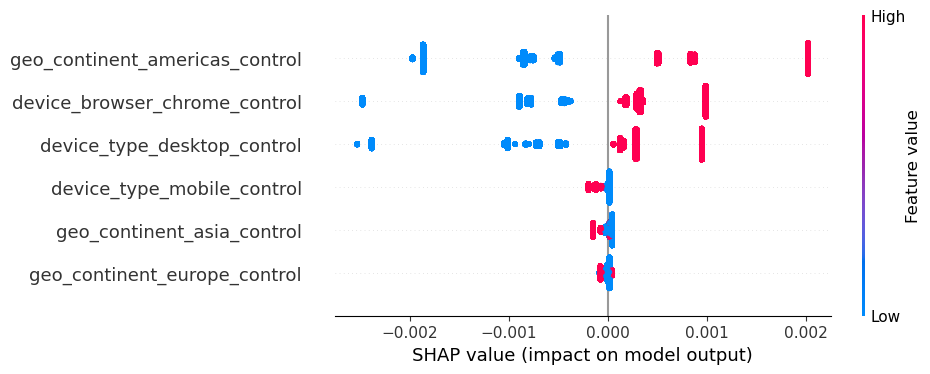

Beeswarm for social_channel_shap_attribution


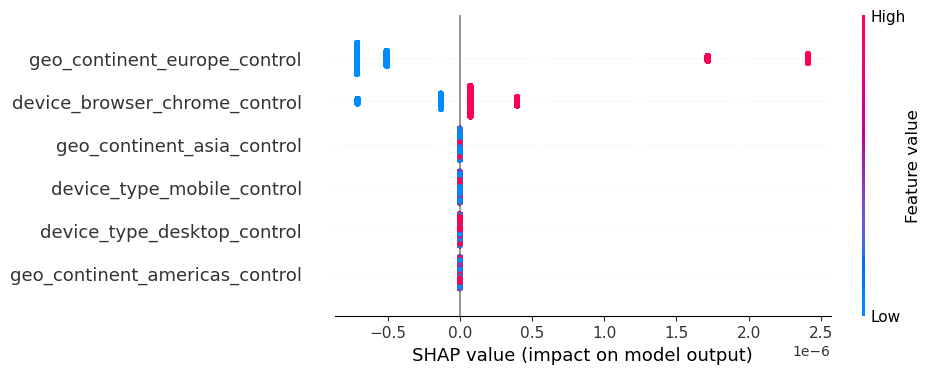

Beeswarm for direct_channel_shap_attribution


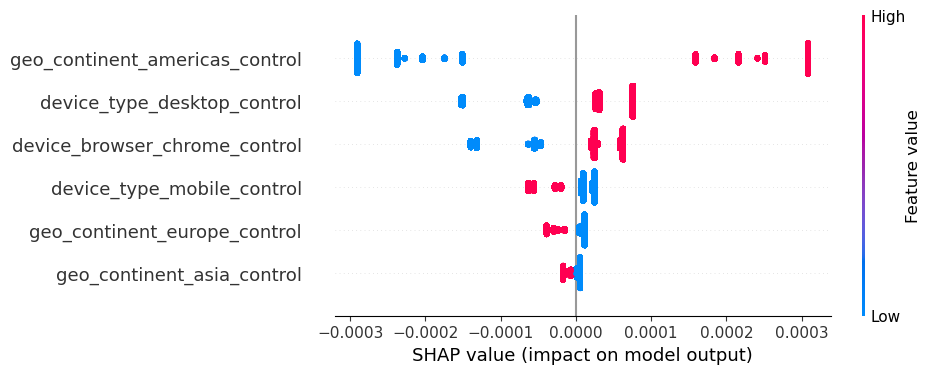

Beeswarm for organic_search_channel_shap_attribution


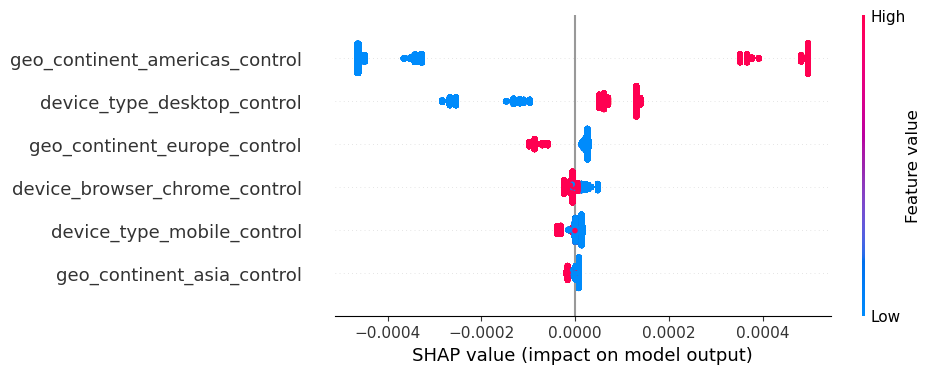

Beeswarm for affiliates_channel_shap_attribution


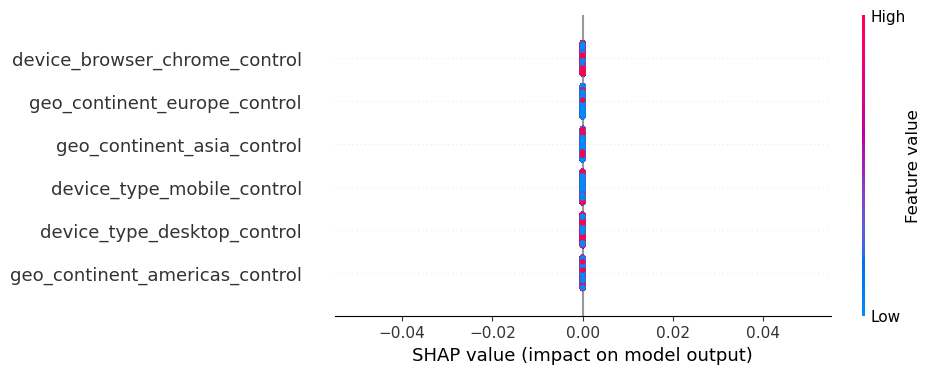

Beeswarm for paid_search_channel_shap_attribution


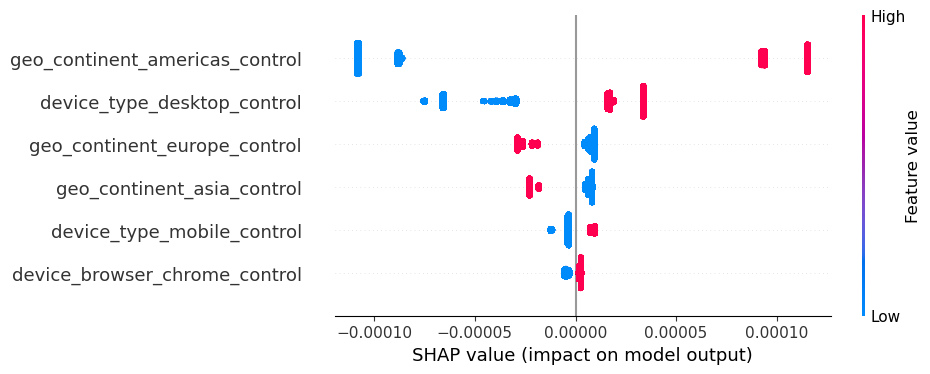

Beeswarm for display_channel_shap_attribution


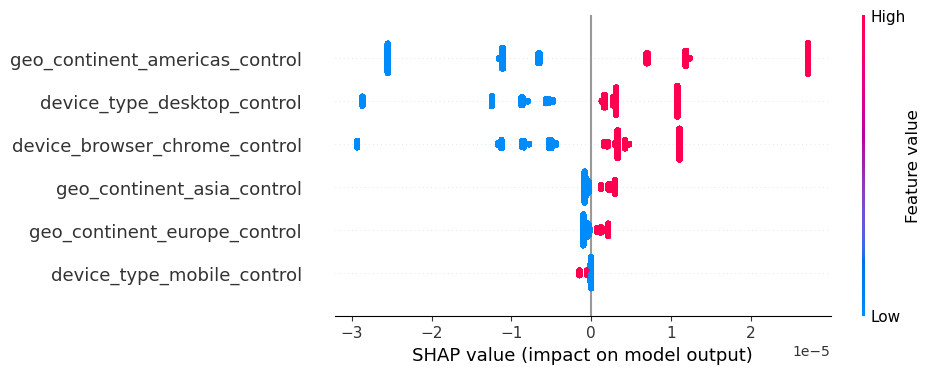

In [36]:
control_vars = [x for x in new_reduced_X_list if '_control' in x]

for i in marketing_vars:

    meta_y = final_results_df.loc[:,'{}'.format(i)]
    meta_X = final_results_df.loc[:,control_vars] 

    # create XGBoost classifier
    meta_xgb = XGBRegressor(eval_metric='rmse')

    # define hyperparameters to tune
    param_grid = {
        'max_depth': [2, 3],
        'learning_rate': [0.01, 0.1],
        'n_estimators': [1000],
        'colsample_bytree': [0.8],
        'subsample': [0.8]
    }

    # create grid search object
    grid_search = GridSearchCV(estimator=meta_xgb, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=0)

    # fit the grid search object to the training data
    grid_search.fit(meta_X, meta_y)

    # get the best hyperparameters from the grid search
    best_params = grid_search.best_params_

    # create XGBoost classifier with best hyperparameters
    best_final_meta_xgb = XGBRegressor(**best_params)

    # fit the classifier to the training data
    best_final_meta_xgb.fit(meta_X, meta_y)

    explainer = shap.Explainer(best_final_meta_xgb)
    shap_values2 = explainer(meta_X)
    
    print('Beeswarm for {}'.format(i))

    # visualize the first prediction's explanation
    shap.plots.beeswarm(shap_values2,  max_display=len(control_vars))

#### Frequency Curves

We will build a synthetic observation where control X's are the most frequent value and marketing Xs are turned off. 

This is an oversimplified way to calculate the baseline probability if no marketing was completed. A weighted average across all observations the model was trained on could be a better way to calculate baseline probability and would give you something closer to the true conversion rate 1.3%. 

Next we can take a single tactic and check frequency 1-10 and see how the probability of conversion changes. 

These can be more useful if they are adapted to an ROI or consider the cost of the touchpoint.

 - Then you can see diminishing returns on investment or the data might shows no diminishing return on investment meaning perhaps there is plenty of room for scaling spend without diminishing ROI.
 
Note our model is aware of frequency but not proximity or sequence. 

In [37]:
X.head()

geo_continent_americas_control  device_type_desktop_control  \
0                               0                            1   
1                               0                            0   
2                               1                            0   
3                               1                            0   
4                               1                            1   

   referral_channel  device_type_mobile_control  social_channel  \
0                 0                           0               0   
1                 0                           1               0   
2                 0                           0               0   
3                 0                           1               0   
4                 1                           0               0   

   direct_channel  geo_continent_asia_control  geo_continent_europe_control  \
0               0                           1                             0   
1               0                           1                             0   
2               0                           0                             0   
3               0                           0                             0   
4               0                           0                             0   

   organic_search_channel  device_browser_chrome_control  affiliates_channel  \
0                       1                              1                   0   
1                       1                              1                   0   
2                       1                              0                   0   
3                       1                              0                   0   
4                       0                              1                   0   

   paid_search_channel  display_channel  
0                    0                0  
1                    0                0  
2                    0                0  
3                    0                0  
4                    0                0

In [48]:
device_type_desktop_control
device_type_mobile_control
device_type_tablet_control
device_browser_chrome_control
device_browser_edge_control
device_browser_firefox_control
device_browser_internet explorer_control
device_browser_other_control
device_browser_safari_control
geo_continent_americas_control
geo_continent_asia_control
geo_continent_europe_control
geo_continent_other_control

['geo_continent_americas_control',
 'device_type_desktop_control',
 'device_type_mobile_control',
 'geo_continent_asia_control',
 'geo_continent_europe_control',
 'device_browser_chrome_control']

In [49]:
## this hardcode doesnt work
syn_X = {'geo_continent_americas_control':1
            ,'device_type_desktop_control':1
            ,'referral_channel':0
            ,'social_channel':0
            ,'device_type_mobile_control':0
            ,'geo_continent_asia_control':0
            ,'direct_channel':0
            ,'geo_continent_europe_control':0
            ,'organic_search_channel':0
            ,'geo_continent_europe_control':0
            ,'device_browser_chrome_control':1
            ,'affiliates_channel':0
            ,'paid_search_channel':0
            ,'device_browser_other_control':0
            ,'display_channel':0
            ,'device_type_tablet_control':0
            ,'device_browser_edge_control':0
            ,'device_browser_firefox_control':0
            ,'device_browser_internet explorer_control':0
            ,'device_browser_safari_control':0
            ,'geo_continent_other_control':0}
syn_X = pd.DataFrame.from_dict(syn_X, orient='index').T

syn_X = syn_X[X.columns]

In [50]:
## Baseline probability of america, desktop, chrome with no marketing
print('Baseline: {:.1%}'.format(best_final_xgb.predict_proba(syn_X)[:, 1][0]))

Baseline: 2.3%


In [52]:
## Now pick a channel and make 11 rows for frequence 0-10 touchpoints

channel_of_interest = 'referral_channel'
frequency_max = 10 ##warning extrapolation by too many values will become unstable if the model never saw frequencies of that level

syn_X2 = pd.concat([syn_X] * (frequency_max+1), ignore_index=True)
syn_X2['{}'.format(channel_of_interest)] = list(range((frequency_max+1)))
syn_X2['Pred'] = best_final_xgb.predict_proba(syn_X2)[:, 1]
syn_X2

geo_continent_americas_control  device_type_desktop_control  \
0                                1                            1   
1                                1                            1   
2                                1                            1   
3                                1                            1   
4                                1                            1   
5                                1                            1   
6                                1                            1   
7                                1                            1   
8                                1                            1   
9                                1                            1   
10                               1                            1   

    referral_channel  device_type_mobile_control  social_channel  \
0                  0                           0               0   
1                  1                           0               0   
2                  2                           0               0   
3                  3                           0               0   
4                  4                           0               0   
5                  5                           0               0   
6                  6                           0               0   
7                  7                           0               0   
8                  8                           0               0   
9                  9                           0               0   
10                10                           0               0   

    direct_channel  geo_continent_asia_control  geo_continent_europe_control  \
0                0                           0                             0   
1                0                           0                             0   
2                0                           0                             0   
3                0                           0                             0   
4                0                           0                             0   
5                0                           0                             0   
6                0                           0                             0   
7                0                           0                             0   
8                0                           0                             0   
9                0                           0                             0   
10               0                           0                             0   

    organic_search_channel  device_browser_chrome_control  affiliates_channel  \
0                        0                              1                   0   
1                        0                              1                   0   
2                        0                              1                   0   
3                        0                              1                   0   
4                        0                              1                   0   
5                        0                              1                   0   
6                        0                              1                   0   
7                        0                              1                   0   
8                        0                              1                   0   
9                        0                              1                   0   
10                       0                              1                   0   

    paid_search_channel  display_channel      Pred  
0                     0                0  0.023386  
1                     0                0  0.063150  
2                     0                0  0.137556  
3                     0                0  0.226543  
4                     0                0  0.230586  
5                     0                0  0.389698  
6                     0                0  0.299772  
7                     0 

In [53]:
line_fig = px.line(syn_X2
                 ,x='{}'.format(channel_of_interest)
                 ,y='Pred'
                 ,title='Probability of conversion by {} frequency'.format(channel_of_interest)
                 ,markers=True
                 )



line_fig.update_layout(width=950
                      ,height=500
                      ,yaxis={'categoryorder': 'total ascending'}
                      ,plot_bgcolor='#f2f2f2') 


line_fig.show()

#### Channel Combinations

Again, we can build a synthetic observation where control X's are the most frequent value and marketing Xs are turned off. This is the baseline probability if no marketing was completed.

However, this time we can take a single tactic, say referral and a combination of tactics say referral and paid search and see the changes in predicted probability.

Note our model is aware of tactic combinations but not the true sequence of touchpoints. Your goal is to improve this so we can look at changes in result due to sequences!

In [70]:

#cols.append('combinations')
cols

['geo_continent_americas_control',
 'device_type_desktop_control',
 'referral_channel',
 'device_type_mobile_control',
 'social_channel',
 'direct_channel',
 'geo_continent_asia_control',
 'geo_continent_europe_control',
 'organic_search_channel',
 'device_browser_chrome_control',
 'affiliates_channel',
 'paid_search_channel',
 'display_channel',
 'combinations']

In [71]:
marketing_vars =  [x for x in X if '_channel' in x]
channel_of_interest = 'referral_channel'

##first create synthetic observation
syn_X_dict = {'geo_continent_americas_control':1
            ,'device_type_desktop_control':1
            ,'referral_channel':0
            ,'social_channel':0
            ,'device_type_mobile_control':0
            ,'geo_continent_asia_control':0
            ,'direct_channel':0
            ,'geo_continent_europe_control':0
            ,'organic_search_channel':0
            ,'geo_continent_europe_control':0
            ,'device_browser_chrome_control':1
            ,'affiliates_channel':0
            ,'paid_search_channel':0
            ,'device_browser_other_control':0
            ,'display_channel':0
            ,'device_type_tablet_control':0
            ,'device_browser_edge_control':0
            ,'device_browser_firefox_control':0
            ,'device_browser_internet explorer_control':0
            ,'device_browser_safari_control':0
            ,'geo_continent_other_control':0}

syn_X_dict[channel_of_interest] = 1
syn_X = pd.DataFrame.from_dict(syn_X_dict, orient='index').T
syn_X = syn_X[X.columns]

syn_X['combinations'] = channel_of_interest

for i in marketing_vars:

    #now create a new combination row
    syn_X_dict_copy = syn_X_dict.copy()
    
    
    if i == channel_of_interest:
        pass
    else:
        syn_X_dict_copy['combinations'] = '{} + {}'.format(channel_of_interest, i)
        syn_X_dict_copy[i] = 1
        syn_X2 = pd.DataFrame.from_dict(syn_X_dict_copy, orient='index').T
        cols = X.columns.tolist() + ['combinations']
        syn_X2 = syn_X2[cols]
        syn_X = pd.concat([syn_X,syn_X2],ignore_index=True)
        
syn_X2 = syn_X.iloc[:,:-1].astype(int)        
syn_X['probability of conversion'] = best_final_xgb.predict_proba(syn_X2)[:, 1]
syn_X

geo_continent_americas_control device_type_desktop_control referral_channel  \
0                              1                           1                1   
1                              1                           1                1   
2                              1                           1                1   
3                              1                           1                1   
4                              1                           1                1   
5                              1                           1                1   
6                              1                           1                1   

  device_type_mobile_control social_channel direct_channel  \
0                          0              0              0   
1                          0              1              0   
2                          0              0              1   
3                          0              0              0   
4                          0              0              0   
5                          0              0              0   
6                          0              0              0   

  geo_continent_asia_control geo_continent_europe_control  \
0                          0                            0   
1                          0                            0   
2                          0                            0   
3                          0                            0   
4                          0                            0   
5                          0                            0   
6                          0                            0   

  organic_search_channel device_browser_chrome_control affiliates_channel  \
0                      0                             1                  0   
1                      0                             1                  0   
2                      0                             1                  0   
3                      1                             1                  0   
4                      0                             1                  1   
5                      0                             1                  0   
6                      0                             1                  0   

  paid_search_channel display_channel  \
0                   0               0   
1                   0               0   
2                   0               0   
3                   0               0   
4                   0               0   
5                   1               0   
6                   0               1   

                                combinations  probability of conversion  
0                           referral_channel                   0.063150  
1          referral_channel + social_channel                   0.007057  
2          referral_channel + direct_channel                   0.085238  
3  referral_channel + organic_search_channel                   0.062236  
4      referral_channel + affiliates_channel                   0.009747  
5     referral_channel + paid_search_channel                   0.154122  
6         referral_channel + display_channel                   0.074819

In [72]:
bar_fig = px.bar(syn_X
                 ,x='probability of conversion'
                 ,y='combinations'
                 ,title='Probability of conversion given different combinations'
                 )

bar_fig.update_layout(width=950
                      ,height=500
                      ,yaxis={'categoryorder': 'total ascending'}
                      ,plot_bgcolor='#f2f2f2') 

bar_fig.show()

#### Random Obs, Waterfall

We can take any single conversion and understand how that credit was divyed up based on the machine learning derived weights.

In [45]:
random_obs = final_results_df.loc[final_results_df['conversion']==1,:].sample(1, random_state=847)

print('random observation index # {}'.format(random_obs.index[0]))

#touches
X_detail_df = random_obs[[col for col in random_obs.columns if 'conversion' not in col and '_shap' not in col]]
X_detail_df = pd.melt(X_detail_df, var_name='Feature', value_name='Value')

#contribution
contribution_vals_df = random_obs.filter(like='shap')
contribution_vals_df = pd.melt(contribution_vals_df, var_name='Feature', value_name='Contribution')
contribution_vals_df.sort_values(by=['Contribution'], ascending=[False],inplace=True)
contribution_vals_df['Feature'] = contribution_vals_df['Feature'].str.replace('_shap_attribution','')

viz_df = contribution_vals_df.merge(X_detail_df, on ='Feature', how ='left')
viz_df.fillna(0,inplace=True)
viz_df['Cumulative Contribution'] = viz_df['Contribution'].cumsum()
viz_df['Feature Detail'] = viz_df['Value'].astype(int).astype(str) + ' | ' + viz_df['Feature']

viz_df = viz_df.loc[viz_df['Contribution']>0,:]

waterfall_fig = go.Figure()

for i in range(len(viz_df)):
    feature = viz_df['Feature Detail'][i]
    contribution = viz_df['Contribution'][i]
    cumulative = viz_df['Cumulative Contribution'][i]
    
    waterfall_fig.add_trace(go.Bar(
         x=[feature]
         ,y=[contribution]
         ,base= cumulative - contribution
         ,text="{:.2f}%".format(contribution)
         ,textposition='outside'
         
     ))
    
waterfall_fig.update_layout(
        title='Contribution Waterfall'
        ,plot_bgcolor='#f9f9f9'
        ,font=dict(family='Segoe UI Semibold', size=12, color='black')
        ,showlegend=False
    )

waterfall_fig.show()

random observation index # 59457


#### Random Obs, Next Best Action

We can take any single observation and understand what an incremental touchpoint from each channel would do in terms of probability lift.

In [46]:
random_obs = final_results_df.sample(1, random_state=847)

print('random observation index # {}'.format(random_obs.index[0]))

marketing_vars = [col for col in random_obs.columns if '_channel' in col and '_shap' not in col]
control_vars = [col for col in random_obs.columns if '_control' in col and '_shap' not in col]

result_df = random_obs.copy()

result_df['next_action'] = 'none'
result_df['pred'] = best_final_xgb.predict_proba(random_obs.loc[:,X.columns])[:, 1]

result_df2 = result_df.copy()

for i in marketing_vars:
    
    result_df3 = result_df.copy()
    
    result_df3['next_action'] = i
    result_df3[i] = result_df3[i]+1
    result_df3['pred'] = best_final_xgb.predict_proba(result_df3.loc[:,X.columns])[:, 1]
    result_df2 = pd.concat([result_df2, result_df3],ignore_index=True)
    
result_df2

random observation index # 19256


geo_continent_americas_control  device_type_desktop_control  \
0                               1                            1   
1                               1                            1   
2                               1                            1   
3                               1                            1   
4                               1                            1   
5                               1                            1   
6                               1                            1   
7                               1                            1   

   referral_channel  device_type_mobile_control  social_channel  \
0                 1                           0               0   
1                 2                           0               0   
2                 1                           0               1   
3                 1                           0               0   
4                 1                           0               0   
5                 1                           0               0   
6                 1                           0               0   
7                 1                           0               0   

   direct_channel  geo_continent_asia_control  geo_continent_europe_control  \
0               0                           0                             0   
1               0                           0                             0   
2               0                           0                             0   
3               1                           0                             0   
4               0                           0                             0   
5               0                           0                             0   
6               0                           0                             0   
7               0                           0                             0   

   organic_search_channel  device_browser_chrome_control  affiliates_channel  \
0                       0                              1                   0   
1                       0                              1                   0   
2                       0                              1                   0   
3                       0                              1                   0   
4                       1                              1                   0   
5                       0                              1                   1   
6                       0                              1                   0   
7                       0                              1                   0   

   paid_search_channel  display_channel  \
0                    0                0   
1                    0                0   
2                    0                0   
3                    0                0   
4                    0                0   
5                    0                0   
6                    1                0   
7                    0                1   

   geo_continent_americas_control_shap_attribution  \
0                                              0.0   
1                                              0.0   
2                                              0.0   
3                                              0.0   
4                                              0.0   
5                                              0.0   
6                                              0.0   
7                                              0.0   

   device_type_desktop_control_shap_attribution  \
0                                           0.0   
1                                           0.0   
2                                           0.0   
3                                           0.0   
4                                           0.0   
5                                           0.0   
6                                           0.0   
7                                           0.0   

   referral_channel_shap_attribution

In [73]:
bar_fig = px.bar(result_df2
                 ,x='pred'
                 ,y='next_action'
                 ,title='Probability of conversion given different next best actions'
                 )

bar_fig.update_layout(width=950
                      ,height=500
                      ,yaxis={'categoryorder': 'total ascending'}
                      ,plot_bgcolor='#f2f2f2') 

bar_fig.show()